# Considerando as imagens satelitais, das mesmas regiões acima, contendo 8 canais espectrais (arquivos .tiff), implemente algum método para segmentação da vegetação presente nas cenas.

In [27]:
import numpy as np
import rasterio
from shapely.geometry import shape, mapping
import cv2
from utils import *


In [21]:
def compute_ndvi(image_path):
    # Open the NIR and Red bands from a multi-band geospatial image    

    with rasterio.open(image_path) as src:
        nir_band = src.read(4)  
        red_band = src.read(3)  

    # Calculate NDVI
    ndvi = (nir_band - red_band) / (nir_band + red_band)

    # Optionally, clip NDVI values to the range [-1, 1]
    ndvi = np.clip(ndvi, -1, 1)
    # Convert the NDVI array to a suitable data type (e.g., float32)   

    return ndvi#.astype(np.float32)

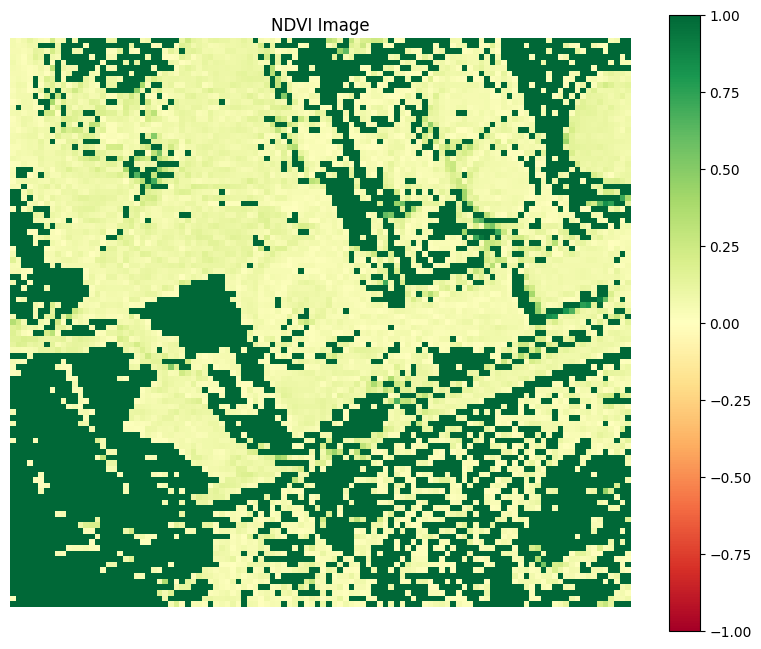

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


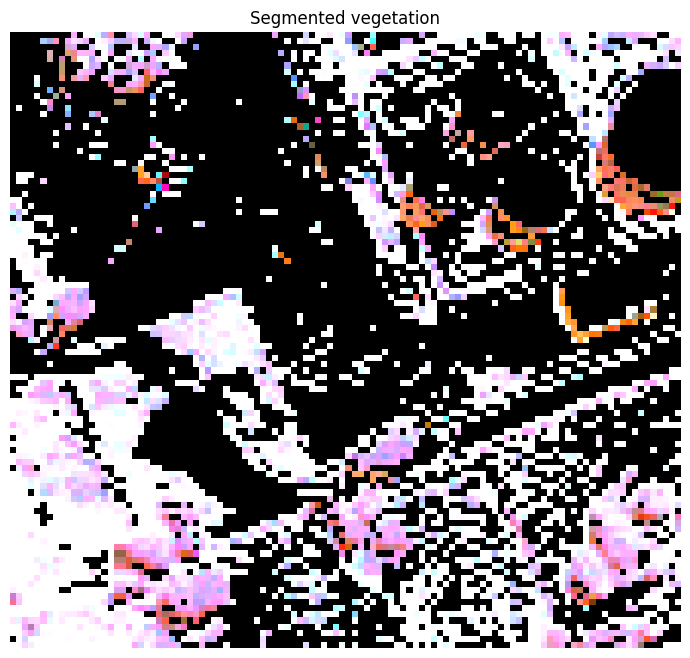

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


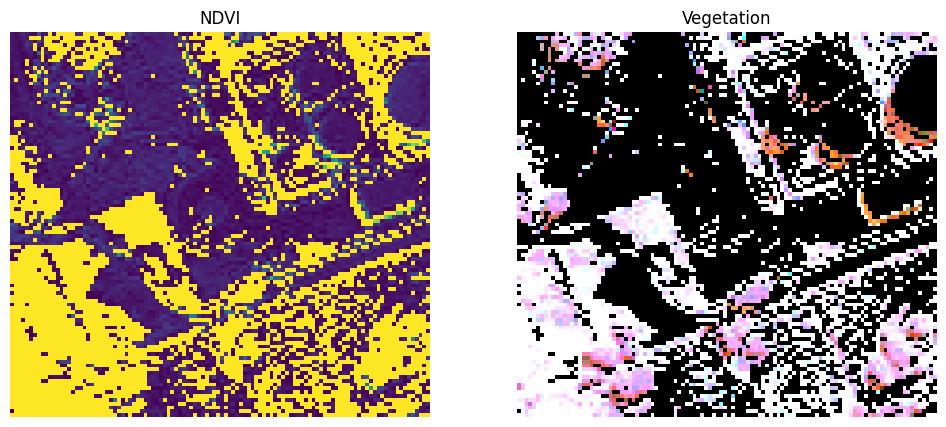

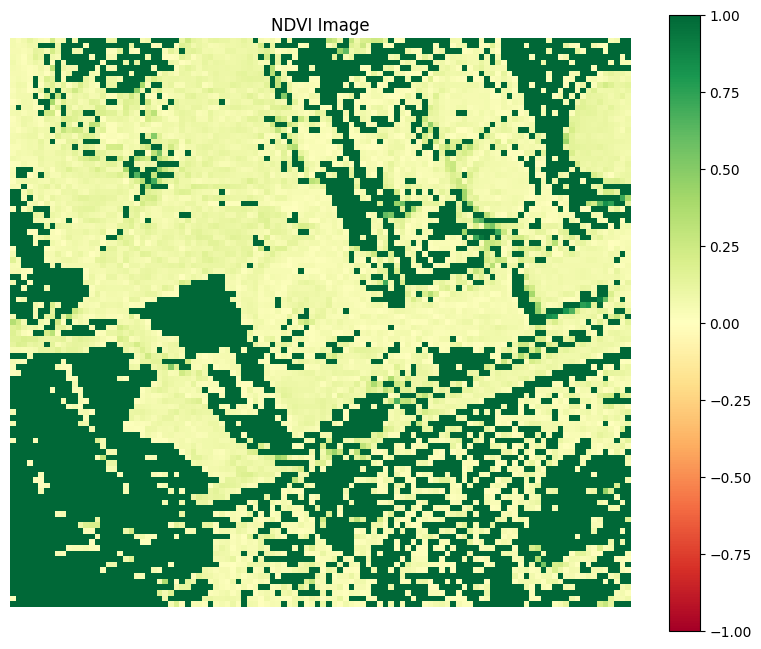

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


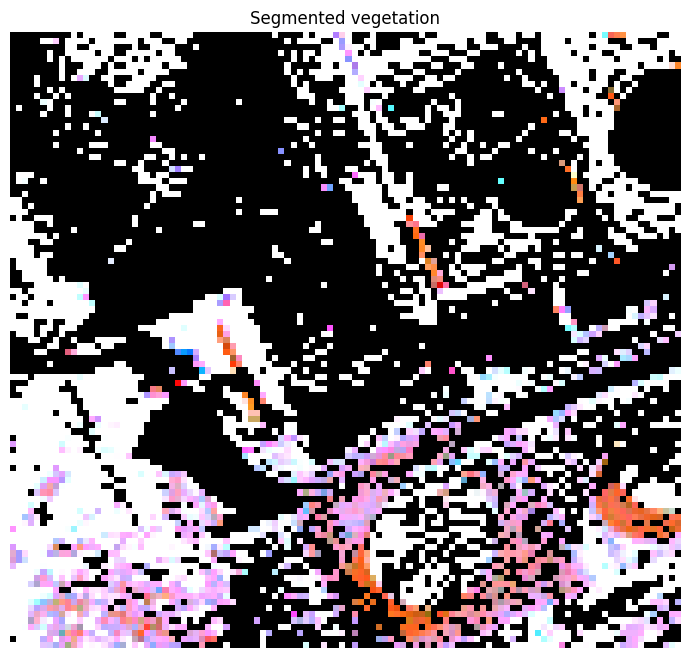

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


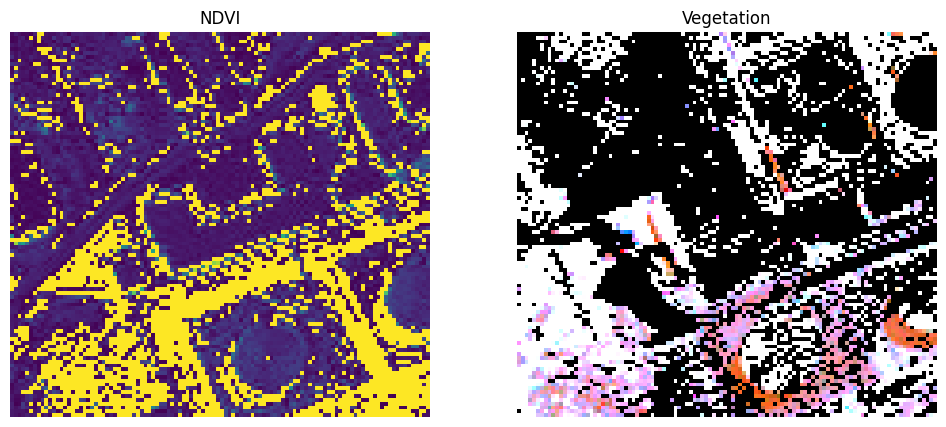

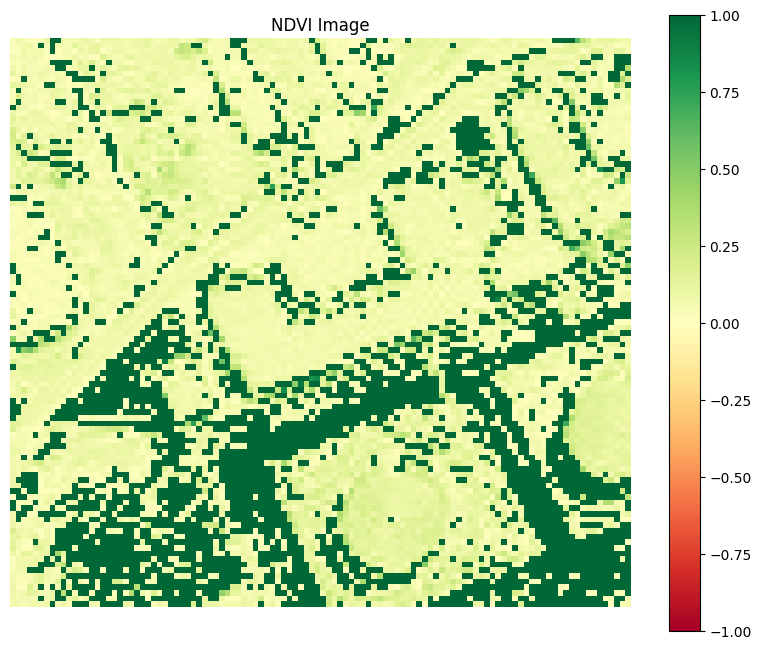

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


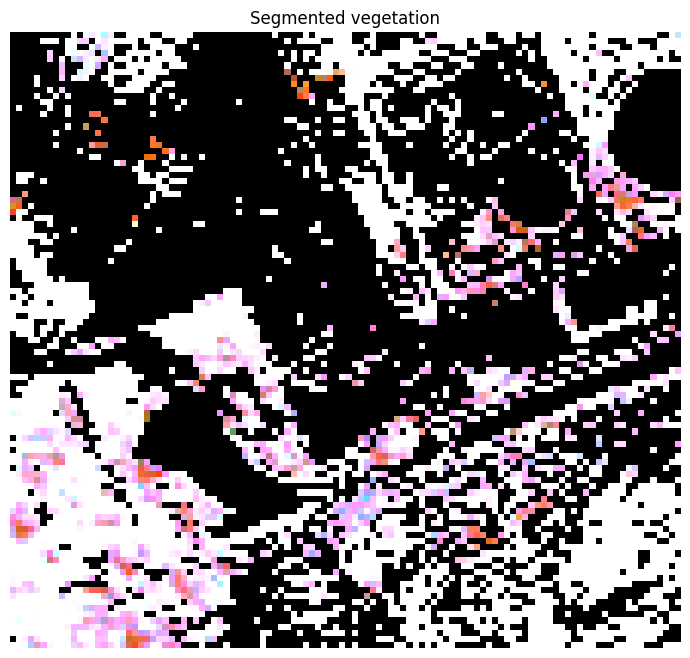

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


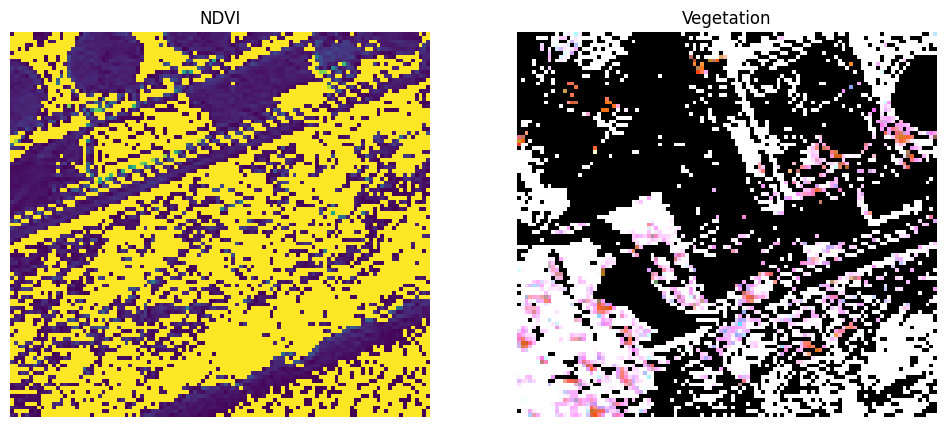

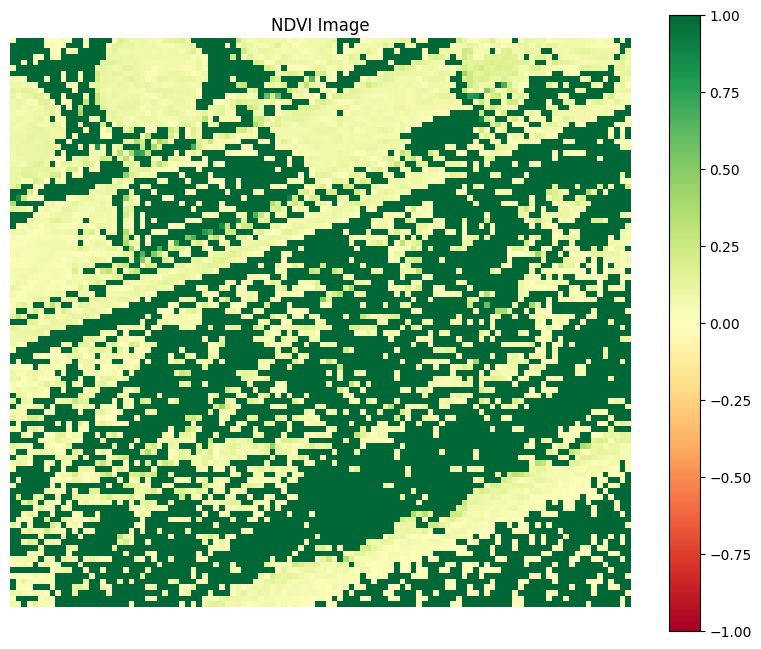

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


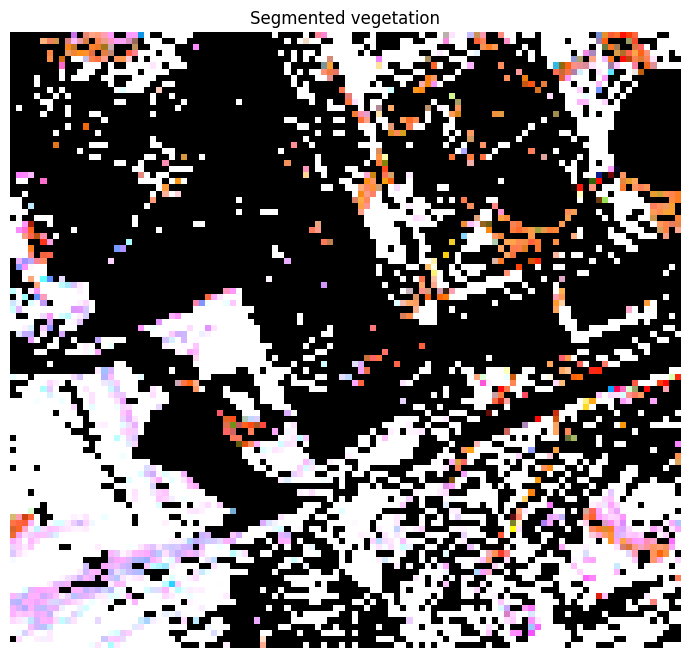

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


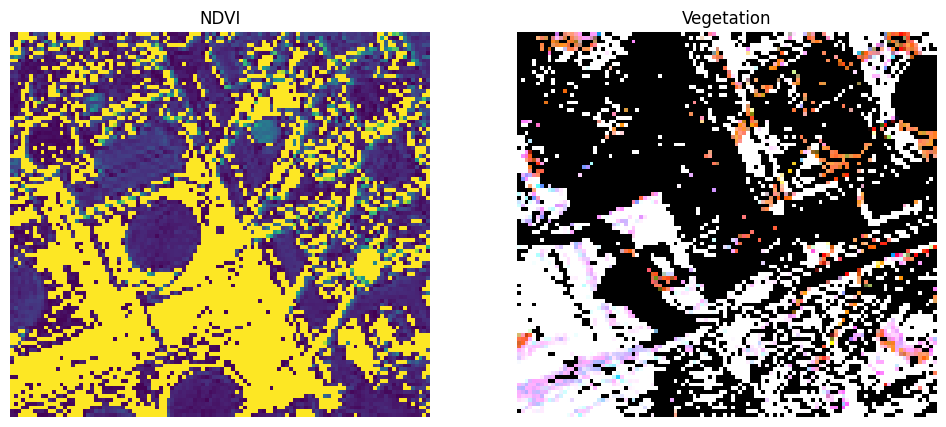

In [45]:
tif_files = list_files('../data/q2',['.tif'])
for tif in tif_files:
    img_name = os.path.basename(tif)
    with rasterio.open(tif) as src:
        red_band = src.read(3)  
        green_band = src.read(2)  
        blue_band = src.read(1)  
    rgb_image = cv2.merge([blue_band, green_band, red_band])
        
    # Create a figure and axis
    plt.figure(figsize=(10, 8))
    plt.imshow(ndvi_tif, cmap='RdYlGn', vmin=-1, vmax=1)
    plt.colorbar()
    plt.title('NDVI Image')
    plt.axis('off')
    # Show the NDVI image
    plt.show()

    ndvi_tif  = compute_ndvi(tif)  
    vegetation_mask = vegetation_mask.astype(np.uint8)  # Convert to uint8
    vegetation_mask = np.where(vegetation_mask > 0.5, 1, 0)  # Ensure it's in the range [0, 1]

    rgb_image[vegetation_mask == 0] = [0,0,0]

    

    # Create a figure and axis
    plt.figure(figsize=(10, 8))
    plt.imshow(rgb_image, cmap=None)    
    plt.title('Segmented vegetation')
    plt.axis('off')
    # Show the NDVI image
    plt.show()


    plot_side_by_side([(ndvi_tif,'NDVI'),(rgb_image,'Vegetation')])





